In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests

In [2]:
#spy=pd.read_csv("data/SPY_weekly.csv")
#spy.rename(columns={'Adj Close':"adj_close"}, inplace=True)
#spy=spy.astype({'Date': 'datetime64'})

In [3]:
d={'function': 'TIME_SERIES_WEEKLY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':'SPY'}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [4]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Weekly Adjusted Time Series'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [5]:
spy=pd.DataFrame({'Date':list(response.json()['Weekly Adjusted Time Series'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


In [6]:
spy=spy.sort_values(by='Date')

In [7]:
spy.tail()

,Date,open,high,low,close,adj_close,volume,dividend
4,2020-03-20,241.18,256.90,228.0200,228.80,228.80,1.512832e+09,1.4056
3,2020-03-27,228.19,262.80,218.2600,253.42,253.42,1.334107e+09,0.0000
2,2020-04-03,255.70,263.33,243.9000,248.19,248.19,8.641470e+08,0.0000
1,2020-04-09,257.84,281.20,248.1698,278.20,278.20,7.284987e+08,0.0000
0,2020-04-17,277.14,287.30,271.4100,286.64,286.64,6.332465e+08,0.0000


In [8]:
def return_percentile(x,window,t='latest',val=0):
    if t=='latest':
        x=x/x.shift(window)-1
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.nanpercentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.nanpercentile(np.sort(x),val)
        

### Returns

In [9]:
return_percentile(spy.adj_close,window=3)

(99.71, 0.1310867334859127)

In [10]:
return_percentile(spy.adj_close,window=3,t='val',val=20)

-0.02170501530157738

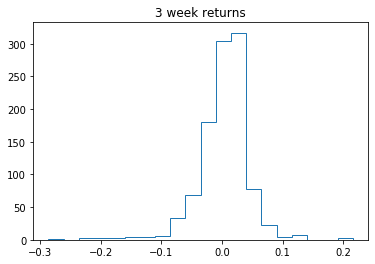

In [11]:
N=3
plt.hist((spy.adj_close/spy.adj_close.shift(N)-1).dropna(), bins=20, histtype='step')
plt.title('{} week returns'.format(N));


### STD

In [ ]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False))

In [ ]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False),t='val',val=90)

In [ ]:
plt.hist(spy.adj_close.rolling(4).apply(np.std, raw=False), bins=30, histtype='step');
plt.title("STD");

### STO

In [ ]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':'SPY','interval':'weekly','fastkperiod':16 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [ ]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })
sto=sto.astype({'Date': 'datetime64'})
sto['sto_diff']=sto['k']-sto['d']

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(sto.sto_diff[sto.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [ ]:
sto=sto.sort_values(by='Date')

In [ ]:
get_percentile(sto.sto_diff)

In [ ]:
get_percentile(sto.sto_diff, t='val', val=30)

In [ ]:
# Diff probably helps more on the downside
get_percentile(sto.sto_diff[sto.sto_diff>=0],t='val',val=90)

In [ ]:
plt.figure(figsize=(20,5))
plt.title("'K'")
plt.vlines(sto.k[1],0,100)
plt.hist(sto.k, bins=50, alpha=0.6);


In [ ]:
N=3
k_change=(sto.sort_values(by='Date').k/sto.sort_values(by='Date').k.shift(N)-1).dropna()

In [ ]:
get_percentile(k_change)

### MACD

In [ ]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [ ]:
spy['macd']=macd
spy['macd_hist']=macd_hist

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(macd_hist[macd_hist>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [ ]:
get_percentile(macd_hist)